In [1]:
import sys
# sys.stdout = open('logfile_geolife', 'w')
sys.path.append('..')

import attack
import data_loader as dl

In [2]:
import geopandas as gp
import pandas as pd
from tqdm import tqdm
import numpy as np
import libpysal
import itertools
from joblib import Parallel, delayed
import random
import matplotlib.pyplot as plt

In [14]:
# Load preprocessed data 
raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf, tesselation_gdf = dl.load_geolife(data_type='raw', 
                                                                                       min_n_trips_per_user=1,
                                                                                       rand_n_week_period=None,
                                                                                       tessellation_diameter=200,
                                                                                       min_trip_length=200,
                                                                                       min_nr_points=50,
                                                                                       upper_quantile_length=0.95,
                                                                                       only_2008=True)
assert len(raw_full_trip_gdf) == len(raw_trip_sp_gdf) == len(raw_trip_ep_gdf)

Reading raw geolife geojson file...
Done.
Number of trajectories in loaded dataset: 5400
Number of users in loaded dataset: 73


In [13]:
from scipy.spatial import distance

def detect_jumps(linestring, jump_dist=1000):
    for i, p in enumerate(linestring.coords):
        if i == len(linestring.coords) - 1:
            continue
        if distance.euclidean(linestring.coords[i], linestring.coords[i+1]) > jump_dist:
            return 1
    return 0

raw_full_trip_gdf['JUMP'] = raw_full_trip_gdf.geometry.apply(lambda x: detect_jumps(x))

raw_full_trip_gdf = raw_full_trip_gdf.query('JUMP == 0').copy()
raw_trip_sp_gdf = raw_trip_sp_gdf.query('TRIP_ID in @raw_full_trip_gdf.TRIP_ID').copy()
raw_trip_ep_gdf = raw_trip_ep_gdf.query('TRIP_ID in @raw_full_trip_gdf.TRIP_ID').copy()

In [5]:
# Parameters
LCSS_EPS = 200
LCSS_FLIP = True

HL_SP_START_TIME = '6:00'
HL_SP_END_TIME = '10:00'
HL_EP_START_TIME = '18:00'
HL_EP_END_TIME = '0:00'

CHAINING_INFLOW_HR_DIFF_THRESHOLD = 4
CHAINING_HR_DIFF_THRESHOLD = 8

HL_SP_OUTFLOW_THRESHOLD = 2
HL_EP_OUTFLOW_THRESHOLD = 4

RANDOMIZED_SIMULTANEOUS_SEARCH_ITERATIONS = 1000

SIM_THRESH_FOR_NO_MATCH_TRIPS = 0.5

# JSD Parameters
GRID_RESOLUTION_JSD = 1000

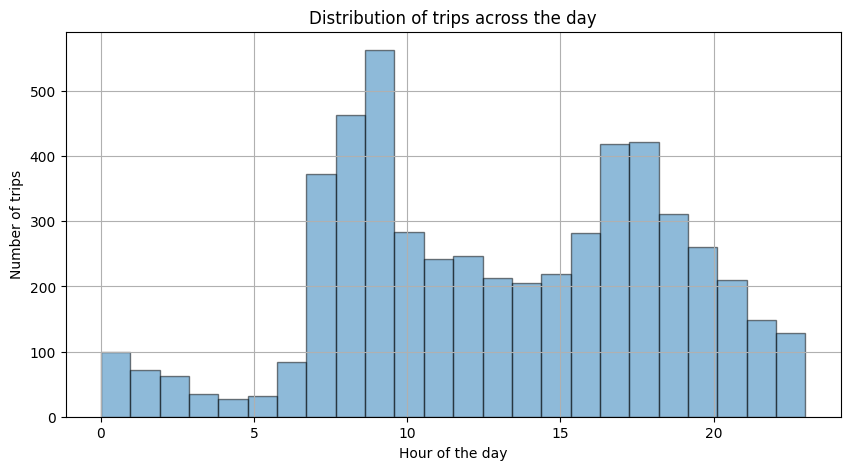

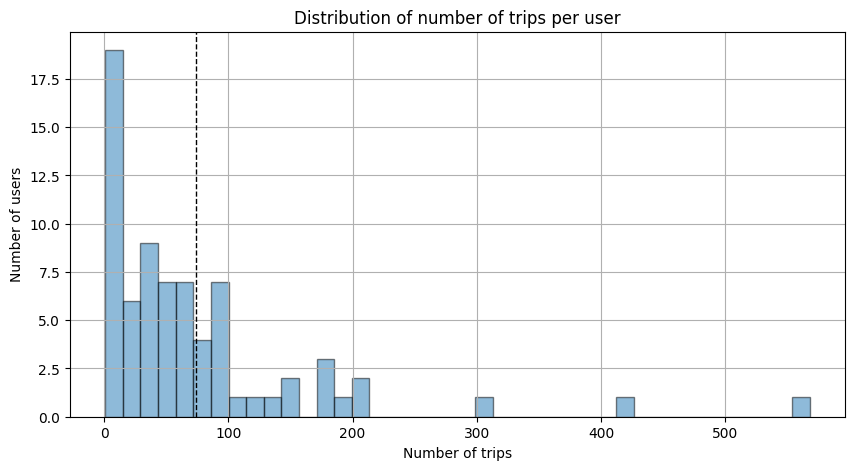

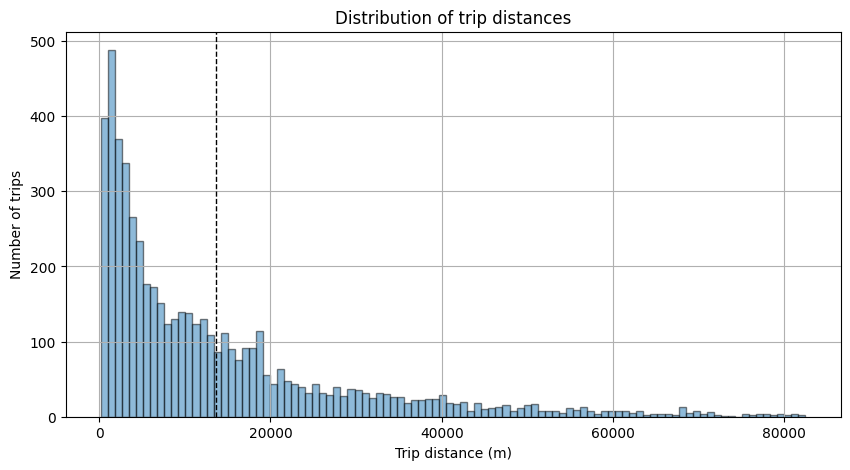

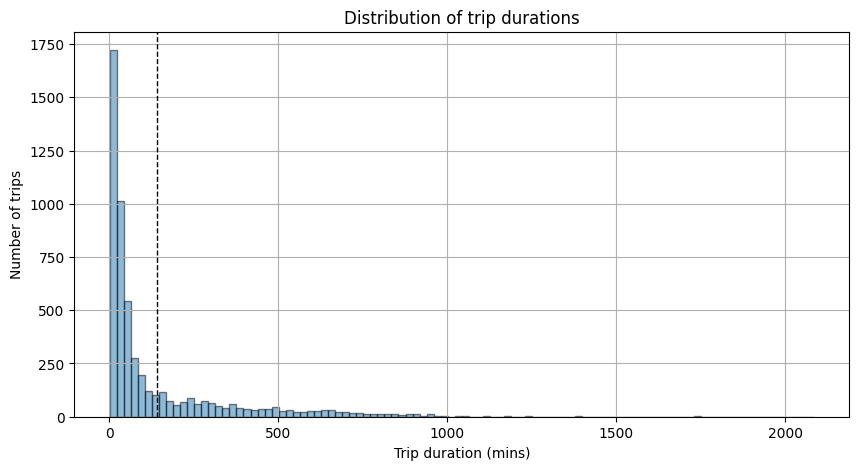


Matching start and end points with tessellation...
Done.

Extracting trips that start and end within tessellation area...
Number of trips that start and end wihin tessellation area: 5101
Number of trips outside and therefore dropped: 299
Done.

Building mapping of trip chains...


100%|███████████████████████████████████████████████████████████████████████████████| 5101/5101 [01:21<00:00, 62.56it/s]


Done.

Evaluating trip chaining...
Number of edges (matched) between trips: 526
Number of wrong matches: 153
Done.

Building trip chains...


100%|████████████████████████████████████████████████████████████████████████████| 5101/5101 [00:00<00:00, 39506.00it/s]


Done.

Merging trips...


100%|███████████████████████████████████████████████████████████████████████████████| 5101/5101 [00:59<00:00, 85.79it/s]


Done.
Number of trips that were matched at least once: 5046/5101
Concatenating MERGED and UNMERGED trips...
Done.

Extracting data for concatenated trips...
Done.

Building clustering after concatenation...
Number of unique clusters: 4630
Done.

Building HL from start points...


/usr/local/lib/python3.8/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 201 disconnected components.
 There are 126 islands with ids: 9, 10, 11, 12, 15, 16, 17, 27, 28, 29, 30, 31, 44, 67, 68, 89, 131, 146, 153, 157, 183, 184, 210, 216, 219, 220, 221, 229, 232, 233, 234, 235, 236, 237, 246, 295, 400, 563, 613, 713, 726, 727, 731, 732, 796, 810, 817, 840, 841, 845, 897, 904, 905, 914, 915, 927, 946, 947, 950, 951, 954, 956, 959, 960, 961, 964, 968, 1000, 1001, 1010, 1011, 1016, 1017, 1024, 1026, 1031, 1034, 1037, 1038, 1048, 1049, 1050, 1055, 1056, 1057, 1058, 1059, 1100, 1136, 1137, 1138, 1139, 1140, 1191, 1192, 1195, 1196, 1208, 1209, 1211, 1213, 1214, 1215, 1220, 1221, 1339, 1341, 1342, 1344, 1345, 1346, 1347, 1348, 1358, 1360, 1361, 1366, 1367, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1408.
  warnings.warn(message)


Done.

Building HL from end points...


/usr/local/lib/python3.8/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 277 disconnected components.
 There are 182 islands with ids: 0, 1, 6, 13, 14, 15, 25, 27, 28, 31, 32, 35, 47, 48, 49, 50, 51, 52, 53, 56, 67, 68, 70, 82, 95, 107, 123, 125, 126, 148, 149, 150, 210, 239, 266, 342, 345, 354, 355, 368, 370, 372, 376, 379, 383, 393, 396, 397, 401, 407, 514, 542, 543, 602, 603, 604, 659, 660, 743, 744, 912, 1018, 1020, 1149, 1169, 1173, 1174, 1177, 1186, 1191, 1220, 1231, 1259, 1260, 1269, 1275, 1338, 1420, 1421, 1422, 1426, 1427, 1430, 1445, 1446, 1471, 1475, 1476, 1477, 1496, 1497, 1498, 1500, 1501, 1502, 1504, 1505, 1506, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1522, 1524, 1563, 1572, 1574, 1576, 1577, 1578, 1580, 1600, 1601, 1607, 1609, 1610, 1612, 1616, 1617, 1625, 1626, 1629, 1630, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1654, 1655, 1659, 1706, 1710, 1748,

Done.

Combining HL from start points and end points...


/usr/local/lib/python3.8/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 339 disconnected components.
 There are 220 islands with ids: 0, 1, 6, 14, 15, 25, 29, 30, 31, 32, 35, 47, 48, 49, 50, 51, 52, 53, 56, 67, 68, 191, 192, 205, 206, 209, 210, 211, 257, 258, 259, 260, 314, 347, 348, 361, 362, 369, 370, 536, 538, 544, 690, 691, 692, 1014, 1015, 1016, 1154, 1155, 1157, 1161, 1163, 1166, 1209, 1213, 1247, 1251, 1273, 1274, 1275, 1413, 1425, 1466, 1467, 1469, 1470, 1474, 1475, 1476, 1497, 1498, 1501, 1502, 1503, 1504, 1505, 1506, 1511, 1512, 1513, 1514, 1516, 1517, 1518, 1523, 1524, 1572, 1596, 1597, 1598, 1599, 1600, 1601, 1609, 1616, 1626, 1629, 1630, 1637, 1638, 1639, 1640, 1641, 1642, 1644, 1646, 1649, 1669, 1670, 1712, 1768, 1769, 1796, 1797, 1866, 1867, 1872, 1873, 1874, 1875, 1889, 1890, 1894, 1895, 1896, 1897, 1902, 2042, 2043, 2044, 2045, 2048, 2049, 2064, 2066, 2069, 2107, 2119, 2120, 2123, 2125, 2135, 2136, 213

Number of users for which at least on Home Location has been identified:  72
Number of unique HL tiles: 339
Done.

Matching trips to HL...
Number of unmatched trajectories (concatenated) that do neither start nor end in a HL tile: 172/4630
Number of trajectories (concatenated) that start AND end in a HL tile: 2930/4630
Number of trips that match different HL tiles with their SP and EP: 1700
Done.

Matching double assigned trips to unique HL...


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.
[Parallel(n_jobs=-4)]: Done 201 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-4)]: Done 551 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-4)]: Done 1001 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-4)]: Done 1551 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-4)]: Done 2201 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-4)]: Done 2951 tasks      | elapsed: 29.3min
[Parallel(n_jobs=-4)]: Done 3400 out of 3400 | elapsed: 34.2min finished
[Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


All scores are 0.0, assigning -1 as best_hl_id!
All scores are 0.0, assigning -1 as best_hl_id!
Done.

Getting trajectories that happened during the same time...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-4)]: Done 550 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-4)]: Done 1000 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-4)]: Done 1550 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-4)]: Done 2200 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-4)]: Done 2950 tasks      | elapsed: 25.7min
[Parallel(n_jobs=-4)]: Done 3800 tasks      | elapsed: 33.1min
[Parallel(n_jobs=-4)]: Done 4630 out of 4630 | elapsed: 40.3min finished


Done.

Building clustering after HL matching step...


  0%|                                                                                           | 0/189 [00:00<?, ?it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Running randomized subset search for 1000 iterations with 34 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    1.7s finished
  4%|███▌                                                                               | 8/189 [00:01<00:41,  4.41it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done. Length of longest subset:  34
Running randomized subset search for 1000 iterations with 478 trajectories...


[Parallel(n_jobs=-4)]: Done 204 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-4)]: Done 751 out of 1000 | elapsed:    7.7s remaining:    2.6s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:   12.0s finished


Done. Length of longest subset:  174


  5%|███▉                                                                               | 9/189 [00:14<06:13,  2.08s/it][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Running randomized subset search for 1000 iterations with 110 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    1.9s finished
  5%|████▎                                                                             | 10/189 [00:16<06:12,  2.08s/it]

Done. Length of longest subset:  88
Running randomized subset search for 1000 iterations with 550 trajectories...


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.
[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    6.6s finished
  7%|█████▋                                                                            | 13/189 [00:23<06:22,  2.17s/it][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done. Length of longest subset:  83
Running randomized subset search for 1000 iterations with 1515 trajectories...


[Parallel(n_jobs=-4)]: Done 205 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-4)]: Done 751 out of 1000 | elapsed:   15.9s remaining:    5.3s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:   23.5s finished


Done. Length of longest subset:  114


  8%|██████▌                                                                           | 15/189 [00:46<14:29,  5.00s/it][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Running randomized subset search for 1000 iterations with 43 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    1.7s finished
  9%|███████▍                                                                          | 17/189 [00:48<10:52,  3.79s/it][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done. Length of longest subset:  43
Running randomized subset search for 1000 iterations with 59 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    1.6s finished
 10%|███████▊                                                                          | 18/189 [00:50<09:48,  3.44s/it][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done. Length of longest subset:  59
Running randomized subset search for 1000 iterations with 65 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    1.8s finished
 11%|████████▋                                                                         | 20/189 [00:52<07:23,  2.63s/it]

Done. Length of longest subset:  65
Running randomized subset search for 1000 iterations with 85 trajectories...


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.
[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    2.6s finished


Done. Length of longest subset:  85


 13%|██████████▊                                                                       | 25/189 [00:55<04:07,  1.51s/it][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Running randomized subset search for 1000 iterations with 38 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    1.3s finished
 14%|███████████▎                                                                      | 26/189 [00:56<04:03,  1.49s/it][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done. Length of longest subset:  34
Running randomized subset search for 1000 iterations with 64 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    1.4s finished
 16%|█████████████▍                                                                    | 31/189 [00:58<02:26,  1.08it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done. Length of longest subset:  64
Running randomized subset search for 1000 iterations with 44 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    1.3s finished
 19%|███████████████▌                                                                  | 36/189 [00:59<01:41,  1.51it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done. Length of longest subset:  44
Running randomized subset search for 1000 iterations with 33 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    1.2s finished
 30%|████████████████████████▎                                                         | 56/189 [01:01<00:32,  4.05it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done. Length of longest subset:  33
Running randomized subset search for 1000 iterations with 32 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    1.0s finished
 31%|█████████████████████████▏                                                        | 58/189 [01:02<00:35,  3.67it/s]

Done. Length of longest subset:  32


 33%|██████████████████████████▉                                                       | 62/189 [01:02<00:28,  4.49it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Running randomized subset search for 1000 iterations with 212 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-4)]: Done 550 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:   18.4s finished


Done. Length of longest subset:  212


 35%|█████████████████████████████                                                     | 67/189 [01:21<02:23,  1.18s/it][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Running randomized subset search for 1000 iterations with 47 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    2.0s finished
 46%|█████████████████████████████████████▋                                            | 87/189 [01:23<00:54,  1.89it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done. Length of longest subset:  47
Running randomized subset search for 1000 iterations with 53 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    1.5s finished
 50%|█████████████████████████████████████████▏                                        | 95/189 [01:25<00:42,  2.23it/s]

Done. Length of longest subset:  53


 74%|███████████████████████████████████████████████████████████▌                     | 139/189 [01:25<00:06,  7.25it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Running randomized subset search for 1000 iterations with 115 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    2.6s finished


Done. Length of longest subset:  106
Running randomized subset search for 1000 iterations with 127 trajectories...


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.
[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-4)]: Done 550 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    5.3s finished


Done. Length of longest subset:  127


 91%|█████████████████████████████████████████████████████████████████████████▋       | 172/189 [01:33<00:02,  5.73it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Running randomized subset search for 1000 iterations with 212 trajectories...


[Parallel(n_jobs=-4)]: Done 201 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    5.5s finished


Done. Length of longest subset:  157


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 183/189 [01:39<00:01,  3.91it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Running randomized subset search for 1000 iterations with 52 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    1.7s finished
100%|█████████████████████████████████████████████████████████████████████████████████| 189/189 [01:41<00:00,  1.86it/s]


Done. Length of longest subset:  52
Done.

Clustering results after concatenation step:
Number of unique clusters: 4630
Homogeneity: 0.991
Completeness: 0.436
V-measure: 0.606
Rand index: 0.965
ARI: 0.002
MI: 3.666
NMI: 0.606
AMI: 0.039
Cluster accuracy: 0.025

Clustering results after HL matching step:
Number of unique clusters: 2626
Homogeneity: 0.899
Completeness: 0.507
V-measure: 0.649
Rand index: 0.968
ARI: 0.261
MI: 3.329
NMI: 0.649
AMI: 0.380
Cluster accuracy: 0.295


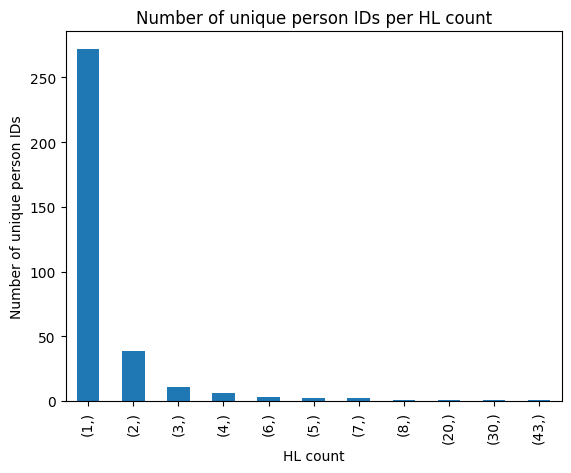

In [15]:
attack.plot_hour_of_day_distribution(raw_full_trip_gdf)
attack.plot_distribution_of_number_of_trips_per_user(raw_full_trip_gdf)
attack.plot_distribution_of_trip_distances(raw_full_trip_gdf)
attack.plot_distribution_of_trip_durations(raw_full_trip_gdf)

# Merge Start Points (SP) and End Points (EP) with Tessellation
print("\nMatching start and end points with tessellation...")
gdf_sp, gdf_ep = attack.match_boundary_points_with_tessellation(raw_trip_sp_gdf, raw_trip_ep_gdf, tesselation_gdf)
print("Done.")

# Extract Full Trips that Start and End within Tessellation Area
print("\nExtracting trips that start and end within tessellation area...")
full_trip_gdf, trip_sp_gdf, trip_ep_gdf, gdf_sp, gdf_ep = attack.extract_trips_that_start_end_in_tessellation(raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf, gdf_sp, gdf_ep)
print("Done.")

# Build mapping of trip chains
print('\nBuilding mapping of trip chains...')
mapping_cont_trips = attack.build_trip_chain_mapping(gdf_sp, gdf_ep)
print('Done.')

# Evaluate Trip Chaining
print('\nEvaluating trip chaining...')
attack.evaluate_trip_chaining(mapping_cont_trips, full_trip_gdf)
print('Done.')

# Concatenate Trips
full_trips_concat_gdf, trip_concat_dict = attack.merge_trips_from_matching(gdf_sp, mapping_cont_trips, full_trip_gdf)

# Extract data for concatenated trips
print('\nExtracting data for concatenated trips...')
gdf_sp_concat, trip_sp_gdf_concat, gdf_ep_concat, trip_ep_gdf_concat = attack.extract_concatenated_trips(full_trips_concat_gdf, gdf_sp, trip_sp_gdf, gdf_ep, trip_ep_gdf)
print('Done.')

# Build Clustering after Concatenation step
print('\nBuilding clustering after concatenation...')
clustering_concat = attack.build_clustering_after_concatenation(full_trips_concat_gdf, trip_concat_dict, full_trip_gdf)
print('Done.')

# Build Home Locations (HL)
# Build HL from Start Points
print('\nBuilding HL from start points...')
gdf_hl_combined_sp = attack.build_hl_from_start_points(gdf_sp, gdf_ep, HL_SP_OUTFLOW_THRESHOLD=HL_SP_OUTFLOW_THRESHOLD)
print('Done.')
# Build HL from End Points
print('\nBuilding HL from end points...')
gdf_hl_combined_ep = attack.build_hl_from_end_points(gdf_sp, gdf_ep, HL_EP_OUTFLOW_THRESHOLD=HL_EP_OUTFLOW_THRESHOLD)
print('Done.')
# Combine HL from Start Points and End Points
print('\nCombining HL from start points and end points...')
gp_combined, HL_table = attack.concatenate_hl(gdf_hl_combined_sp, gdf_hl_combined_ep)
print('Done.')

print('\nMatching trips to HL...')
HL_table_se_concat, unmatched_trips, double_assigned_trips, nr_unmatched = attack.match_trips_to_HL(gp_combined, HL_table, trip_sp_gdf_concat, trip_ep_gdf_concat, full_trips_concat_gdf)
print('Done.')

print('\nMatching double assigned trips to unique HL...')
HL_table_trips_concat = attack.assign_double_matched_trips_to_unique_hl(HL_table_se_concat, full_trips_concat_gdf, unmatched_trips, double_assigned_trips, nr_unmatched)
print('Done.')

# Get trajectories that happened during the same time
print('\nGetting trajectories that happened during the same time...')
full_trips_concat_gdf_overlap_dict = attack.getTripOverlaps(full_trips_concat_gdf)
print('Done.')

# Build Clustering after HL matching step
print('\nBuilding clustering after HL matching step...')
clustering_after_HL, HL_table_dict = attack.build_clustering_after_HL_assignment(HL_table_trips_concat, full_trip_gdf, trip_concat_dict, full_trips_concat_gdf_overlap_dict)
print('Done.')

# Evaluate clustering Results
print("\nClustering results after concatenation step:")
print(f"Number of unique clusters: {len(set(clustering_concat))}")
attack.evaluate(clustering_concat, full_trip_gdf)
clustering_HL = list(dict(sorted(clustering_after_HL.items())).values())
print("\nClustering results after HL matching step:")
print(f"Number of unique clusters: {len(set(clustering_HL))}")
attack.evaluate(clustering_HL, full_trip_gdf)

In [16]:
full_trip_gdf = full_trip_gdf.copy()
full_trip_gdf['clustering_HL'] = clustering_HL
full_trip_gdf.to_file('../data/geolife/geolife_clustering_HL.geojson', driver="GeoJSON")

/usr/local/lib/python3.8/dist-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [3]:
# Load preprocessed data 
raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf, tesselation_gdf = dl.load_geolife(data_type='private', 
                                                                                       min_n_trips_per_user=1,
                                                                                       rand_n_week_period=None,
                                                                                       tessellation_diameter=200,
                                                                                       min_trip_length=200,
                                                                                       min_nr_points=50,
                                                                                       upper_quantile_length=0.95,
                                                                                       only_2008=True)
assert len(raw_full_trip_gdf) == len(raw_trip_sp_gdf) == len(raw_trip_ep_gdf)

Reading private geolife geojson file...
Done.
Number of trajectories in loaded dataset: 4719
Number of users in loaded dataset: 73


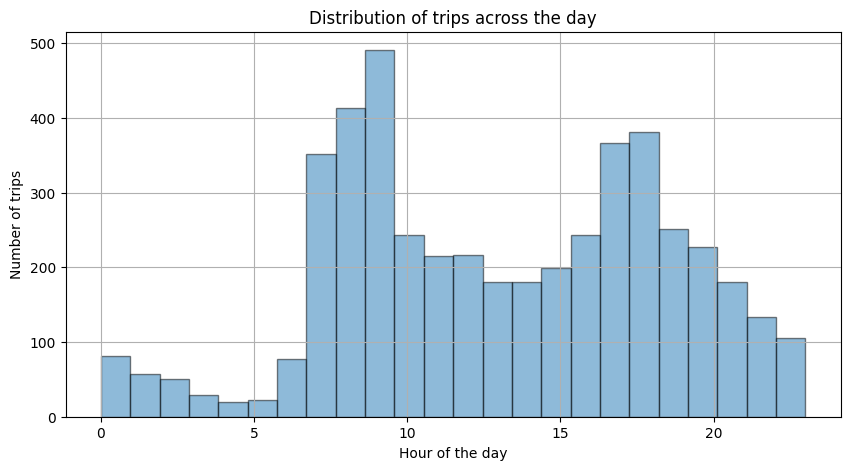

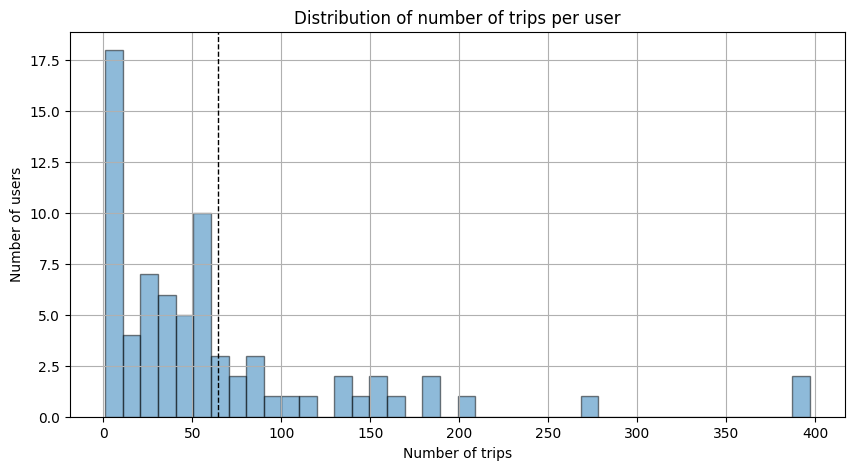

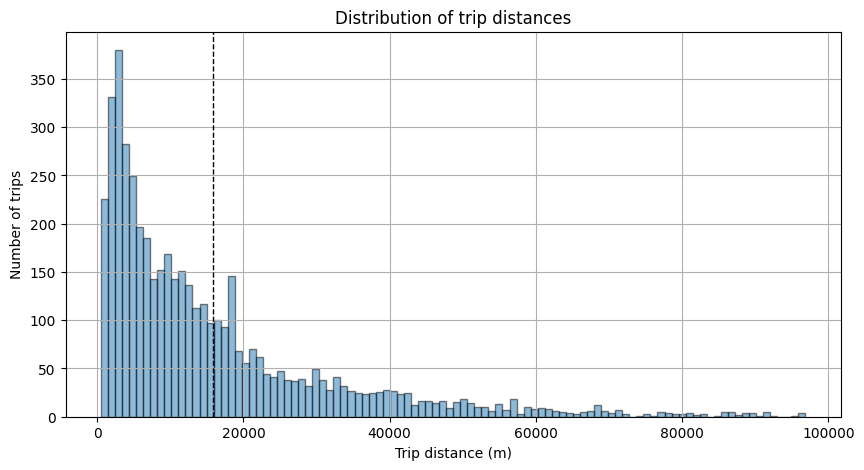

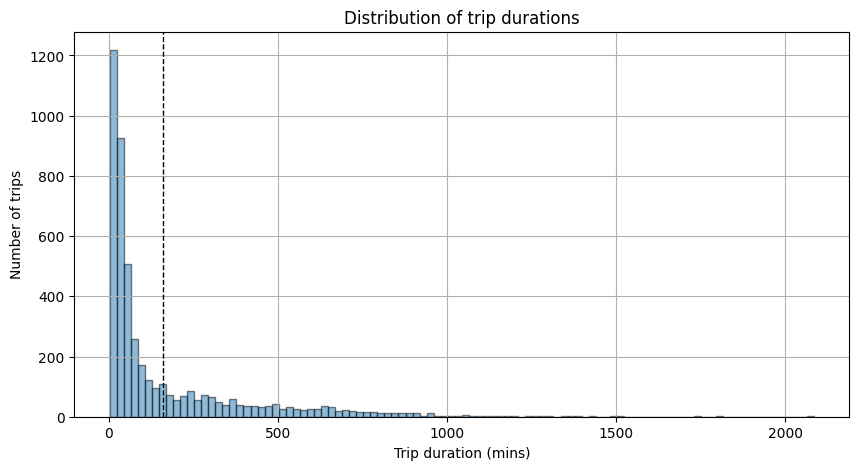


Matching start and end points with tessellation...
Done.

Extracting trips that start and end within tessellation area...
Number of trips that start and end wihin tessellation area: 4449
Number of trips outside and therefore dropped: 270
Done.

Building mapping of trip chains...


100%|███████████████████████████████████████████████████████████████████████████████| 4449/4449 [01:10<00:00, 62.89it/s]


Done.

Evaluating trip chaining...
Number of edges (matched) between trips: 145
Number of wrong matches: 75
Done.

Building trip chains...


100%|███████████████████████████████████████████████████████████████████████████| 4449/4449 [00:00<00:00, 153359.35it/s]


Done.

Merging trips...


100%|███████████████████████████████████████████████████████████████████████████████| 4449/4449 [00:53<00:00, 82.44it/s]


Done.
Number of trips that were matched at least once: 4443/4449
Concatenating MERGED and UNMERGED trips...
Done.

Extracting data for concatenated trips...
Done.

Building clustering after concatenation...
Number of unique clusters: 4310
Done.

Building HL from start points...


/usr/local/lib/python3.8/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 214 disconnected components.
 There are 136 islands with ids: 8, 9, 12, 13, 14, 24, 25, 26, 27, 28, 29, 38, 42, 52, 62, 93, 103, 108, 120, 121, 126, 127, 137, 149, 152, 171, 173, 175, 178, 179, 181, 183, 190, 193, 199, 208, 212, 239, 313, 358, 584, 622, 641, 661, 689, 690, 694, 736, 737, 738, 803, 804, 808, 816, 825, 846, 847, 851, 855, 857, 860, 861, 863, 864, 868, 872, 876, 906, 907, 908, 909, 913, 916, 917, 918, 919, 923, 924, 929, 930, 931, 938, 939, 940, 941, 942, 950, 951, 952, 953, 956, 957, 958, 967, 968, 1029, 1030, 1065, 1072, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1086, 1087, 1088, 1089, 1090, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1209, 1210, 1214, 1215, 1216, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1234, 1235, 1267, 1269, 1270.
  warnings.warn(message)


Done.

Building HL from end points...


/usr/local/lib/python3.8/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 264 disconnected components.
 There are 186 islands with ids: 0, 1, 5, 9, 10, 11, 17, 25, 26, 27, 29, 31, 35, 36, 43, 44, 45, 46, 47, 48, 49, 50, 53, 60, 62, 73, 75, 82, 84, 91, 103, 107, 128, 136, 139, 161, 173, 181, 183, 267, 281, 302, 309, 314, 315, 316, 317, 318, 319, 320, 322, 329, 330, 331, 333, 356, 357, 358, 452, 489, 602, 875, 963, 971, 972, 991, 992, 1031, 1056, 1057, 1064, 1088, 1101, 1102, 1118, 1126, 1148, 1155, 1248, 1249, 1251, 1252, 1263, 1264, 1272, 1282, 1283, 1285, 1292, 1293, 1296, 1297, 1308, 1328, 1336, 1337, 1342, 1345, 1347, 1348, 1349, 1352, 1353, 1354, 1356, 1357, 1358, 1363, 1367, 1408, 1418, 1421, 1422, 1423, 1425, 1431, 1432, 1433, 1434, 1439, 1440, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1457, 1459, 1464, 1465, 1466, 1467, 1468, 1474, 1475, 1476, 1477, 1478, 1482, 1485, 1489, 1507, 1508, 1522, 1529, 1550,

Done.

Combining HL from start points and end points...


/usr/local/lib/python3.8/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 349 disconnected components.
 There are 234 islands with ids: 0, 1, 5, 10, 11, 20, 25, 26, 27, 30, 31, 41, 43, 44, 45, 46, 47, 48, 49, 54, 60, 71, 186, 228, 229, 231, 257, 262, 263, 264, 265, 268, 269, 270, 301, 308, 315, 325, 990, 991, 1128, 1129, 1130, 1133, 1134, 1139, 1140, 1141, 1142, 1143, 1144, 1182, 1183, 1186, 1208, 1210, 1211, 1244, 1245, 1318, 1321, 1324, 1325, 1326, 1327, 1328, 1331, 1332, 1334, 1339, 1345, 1346, 1348, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1369, 1415, 1433, 1437, 1438, 1439, 1440, 1441, 1443, 1444, 1445, 1446, 1447, 1448, 1450, 1451, 1458, 1461, 1464, 1465, 1466, 1467, 1468, 1475, 1477, 1531, 1534, 1535, 1538, 1539, 1587, 1617, 1618, 1621, 1624, 1685, 1686, 1687, 1688, 1691, 1692, 1695, 1696, 1697, 1700, 1704, 1705, 1712, 1714, 1715, 1716, 1717, 1720, 1721, 1857, 1859, 1860, 1863, 1874, 1878, 1879, 1880, 1916, 1926,

Number of users for which at least on Home Location has been identified:  71
Number of unique HL tiles: 349
Done.

Matching trips to HL...
Number of unmatched trajectories (concatenated) that do neither start nor end in a HL tile: 223/4310
Number of trajectories (concatenated) that start AND end in a HL tile: 2524/4310
Number of trips that match different HL tiles with their SP and EP: 1200
Done.

Matching double assigned trips to unique HL...


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.
[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-4)]: Done 550 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-4)]: Done 1000 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-4)]: Done 1550 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-4)]: Done 2400 out of 2400 | elapsed: 23.6min finished
[Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


All scores are 0.0, assigning -1 as best_hl_id!
All scores are 0.0, assigning -1 as best_hl_id!
All scores are 0.0, assigning -1 as best_hl_id!
All scores are 0.0, assigning -1 as best_hl_id!
All scores are 0.0, assigning -1 as best_hl_id!
All scores are 0.0, assigning -1 as best_hl_id!
All scores are 0.0, assigning -1 as best_hl_id!
Done.

Getting trajectories that happened during the same time...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-4)]: Done 550 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-4)]: Done 1000 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-4)]: Done 1550 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-4)]: Done 2200 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-4)]: Done 2950 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-4)]: Done 3800 tasks      | elapsed: 26.7min
[Parallel(n_jobs=-4)]: Done 4310 out of 4310 | elapsed: 30.3min finished


Done.

Building clustering after HL matching step...


  0%|                                                                                           | 0/210 [00:00<?, ?it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Running randomized subset search for 1000 iterations with 36 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    1.8s finished
  2%|█▉                                                                                 | 5/210 [00:01<01:18,  2.61it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done. Length of longest subset:  36
Running randomized subset search for 1000 iterations with 94 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    1.6s finished
  3%|██▊                                                                                | 7/210 [00:03<01:53,  1.79it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done. Length of longest subset:  75
Running randomized subset search for 1000 iterations with 314 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-4)]: Done 550 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    9.2s finished


Done. Length of longest subset:  183


  4%|███▌                                                                               | 9/210 [00:13<06:40,  1.99s/it][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Running randomized subset search for 1000 iterations with 2049 trajectories...


[Parallel(n_jobs=-4)]: Done 205 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:   24.2s finished
  8%|██████▏                                                                           | 16/210 [00:37<09:30,  2.94s/it][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done. Length of longest subset:  92
Running randomized subset search for 1000 iterations with 212 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-4)]: Done 550 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:   17.8s finished


Done. Length of longest subset:  212


  8%|██████▋                                                                           | 17/210 [00:55<15:03,  4.68s/it][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Running randomized subset search for 1000 iterations with 58 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    1.9s finished
 10%|███████▊                                                                          | 20/210 [00:57<10:38,  3.36s/it][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done. Length of longest subset:  57
Running randomized subset search for 1000 iterations with 46 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    1.5s finished
 10%|████████▏                                                                         | 21/210 [00:59<09:49,  3.12s/it][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done. Length of longest subset:  46
Running randomized subset search for 1000 iterations with 62 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    1.5s finished
 10%|████████▌                                                                         | 22/210 [01:01<09:01,  2.88s/it][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done. Length of longest subset:  62
Running randomized subset search for 1000 iterations with 44 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    1.4s finished
 13%|██████████▉                                                                       | 28/210 [01:02<04:05,  1.35s/it][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done. Length of longest subset:  40
Running randomized subset search for 1000 iterations with 66 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    1.4s finished
 14%|███████████▋                                                                      | 30/210 [01:04<03:39,  1.22s/it][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done. Length of longest subset:  66
Running randomized subset search for 1000 iterations with 103 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    1.7s finished
 15%|████████████▍                                                                     | 32/210 [01:05<03:24,  1.15s/it]

Done. Length of longest subset:  90
Running randomized subset search for 1000 iterations with 45 trajectories...


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.
[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-4)]: Done 550 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    2.0s finished
 18%|██████████████▊                                                                   | 38/210 [01:07<02:08,  1.33it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done. Length of longest subset:  45
Running randomized subset search for 1000 iterations with 31 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    1.0s finished
 29%|███████████████████████▍                                                          | 60/210 [01:09<00:36,  4.10it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done. Length of longest subset:  31
Running randomized subset search for 1000 iterations with 40 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    1.1s finished
 43%|███████████████████████████████████▌                                              | 91/210 [01:10<00:14,  8.08it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done. Length of longest subset:  40
Running randomized subset search for 1000 iterations with 76 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    1.7s finished
 54%|███████████████████████████████████████████▉                                     | 114/210 [01:12<00:10,  9.29it/s]

Done. Length of longest subset:  76


 72%|██████████████████████████████████████████████████████████▋                      | 152/210 [01:12<00:03, 17.34it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Running randomized subset search for 1000 iterations with 114 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    2.6s finished


Done. Length of longest subset:  114


 80%|████████████████████████████████████████████████████████████████▊                | 168/210 [01:15<00:03, 11.85it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Running randomized subset search for 1000 iterations with 250 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    4.7s finished


Done. Length of longest subset:  140


100%|█████████████████████████████████████████████████████████████████████████████████| 210/210 [01:20<00:00,  2.62it/s]


Done.

Clustering results after concatenation step:
Number of unique clusters: 4310
Homogeneity: 0.994
Completeness: 0.440
V-measure: 0.610
Rand index: 0.967
ARI: 0.000
MI: 3.678
NMI: 0.610
AMI: 0.008
Cluster accuracy: 0.022

Clustering results after HL matching step:
Number of unique clusters: 2675
Homogeneity: 0.915
Completeness: 0.502
V-measure: 0.649
Rand index: 0.970
ARI: 0.262
MI: 3.387
NMI: 0.649
AMI: 0.335
Cluster accuracy: 0.276


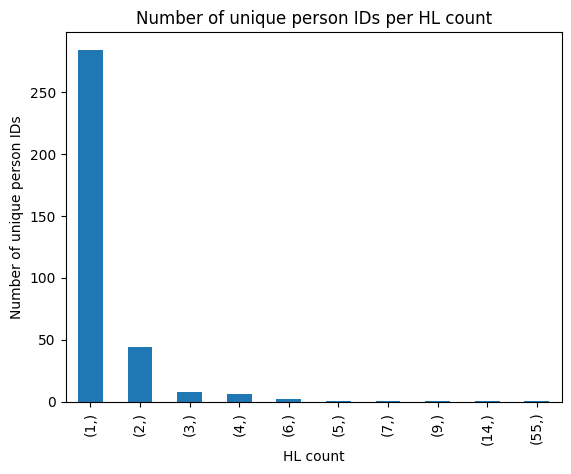

In [6]:
# Run attack on private data
attack.plot_hour_of_day_distribution(raw_full_trip_gdf)
attack.plot_distribution_of_number_of_trips_per_user(raw_full_trip_gdf)
attack.plot_distribution_of_trip_distances(raw_full_trip_gdf)
attack.plot_distribution_of_trip_durations(raw_full_trip_gdf)

# Merge Start Points (SP) and End Points (EP) with Tessellation
print("\nMatching start and end points with tessellation...")
gdf_sp, gdf_ep = attack.match_boundary_points_with_tessellation(raw_trip_sp_gdf, raw_trip_ep_gdf, tesselation_gdf)
print("Done.")

# Extract Full Trips that Start and End within Tessellation Area
print("\nExtracting trips that start and end within tessellation area...")
full_trip_gdf, trip_sp_gdf, trip_ep_gdf, gdf_sp, gdf_ep = attack.extract_trips_that_start_end_in_tessellation(raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf, gdf_sp, gdf_ep)
print("Done.")

# Build mapping of trip chains
print('\nBuilding mapping of trip chains...')
mapping_cont_trips = attack.build_trip_chain_mapping(gdf_sp, gdf_ep)
print('Done.')

# Evaluate Trip Chaining
print('\nEvaluating trip chaining...')
attack.evaluate_trip_chaining(mapping_cont_trips, full_trip_gdf)
print('Done.')

# Concatenate Trips
full_trips_concat_gdf, trip_concat_dict = attack.merge_trips_from_matching(gdf_sp, mapping_cont_trips, full_trip_gdf)

# Extract data for concatenated trips
print('\nExtracting data for concatenated trips...')
gdf_sp_concat, trip_sp_gdf_concat, gdf_ep_concat, trip_ep_gdf_concat = attack.extract_concatenated_trips(full_trips_concat_gdf, gdf_sp, trip_sp_gdf, gdf_ep, trip_ep_gdf)
print('Done.')

# Build Clustering after Concatenation step
print('\nBuilding clustering after concatenation...')
clustering_concat = attack.build_clustering_after_concatenation(full_trips_concat_gdf, trip_concat_dict, full_trip_gdf)
print('Done.')

# Build Home Locations (HL)
# Build HL from Start Points
print('\nBuilding HL from start points...')
gdf_hl_combined_sp = attack.build_hl_from_start_points(gdf_sp, gdf_ep, HL_SP_OUTFLOW_THRESHOLD=HL_SP_OUTFLOW_THRESHOLD)
print('Done.')
# Build HL from End Points
print('\nBuilding HL from end points...')
gdf_hl_combined_ep = attack.build_hl_from_end_points(gdf_sp, gdf_ep, HL_EP_OUTFLOW_THRESHOLD=HL_EP_OUTFLOW_THRESHOLD)
print('Done.')
# Combine HL from Start Points and End Points
print('\nCombining HL from start points and end points...')
gp_combined, HL_table = attack.concatenate_hl(gdf_hl_combined_sp, gdf_hl_combined_ep)
print('Done.')

print('\nMatching trips to HL...')
HL_table_se_concat, unmatched_trips, double_assigned_trips, nr_unmatched = attack.match_trips_to_HL(gp_combined, HL_table, trip_sp_gdf_concat, trip_ep_gdf_concat, full_trips_concat_gdf)
print('Done.')

print('\nMatching double assigned trips to unique HL...')
HL_table_trips_concat = attack.assign_double_matched_trips_to_unique_hl(HL_table_se_concat, full_trips_concat_gdf, unmatched_trips, double_assigned_trips, nr_unmatched)
print('Done.')

# Get trajectories that happened during the same time
print('\nGetting trajectories that happened during the same time...')
full_trips_concat_gdf_overlap_dict = attack.getTripOverlaps(full_trips_concat_gdf)
print('Done.')

# Build Clustering after HL matching step
print('\nBuilding clustering after HL matching step...')
clustering_after_HL, HL_table_dict = attack.build_clustering_after_HL_assignment(HL_table_trips_concat, full_trip_gdf, trip_concat_dict, full_trips_concat_gdf_overlap_dict)
print('Done.')

# Evaluate clustering Results
print("\nClustering results after concatenation step:")
print(f"Number of unique clusters: {len(set(clustering_concat))}")
attack.evaluate(clustering_concat, full_trip_gdf)
clustering_HL = list(dict(sorted(clustering_after_HL.items())).values())
print("\nClustering results after HL matching step:")
print(f"Number of unique clusters: {len(set(clustering_HL))}")
attack.evaluate(clustering_HL, full_trip_gdf)

In [7]:
full_trip_gdf = full_trip_gdf.copy()
full_trip_gdf['clustering_HL'] = clustering_HL
full_trip_gdf.to_file('../data/geolife/geolife_clustering_HL_private.geojson', driver="GeoJSON")

/usr/local/lib/python3.8/dist-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [11]:
# Load preprocessed data 
raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf, tesselation_gdf = dl.load_geolife(data_type='raw', 
                                                                                       min_n_trips_per_user=1,
                                                                                       rand_n_week_period=None,
                                                                                       tessellation_diameter=500,
                                                                                       min_trip_length=200,
                                                                                       min_nr_points=50,
                                                                                       upper_quantile_length=0.95,
                                                                                       only_2008=True)
assert len(raw_full_trip_gdf) == len(raw_trip_sp_gdf) == len(raw_trip_ep_gdf)

Reading raw geolife geojson file...
Done.
Number of trajectories in loaded dataset: 5400
Number of users in loaded dataset: 73


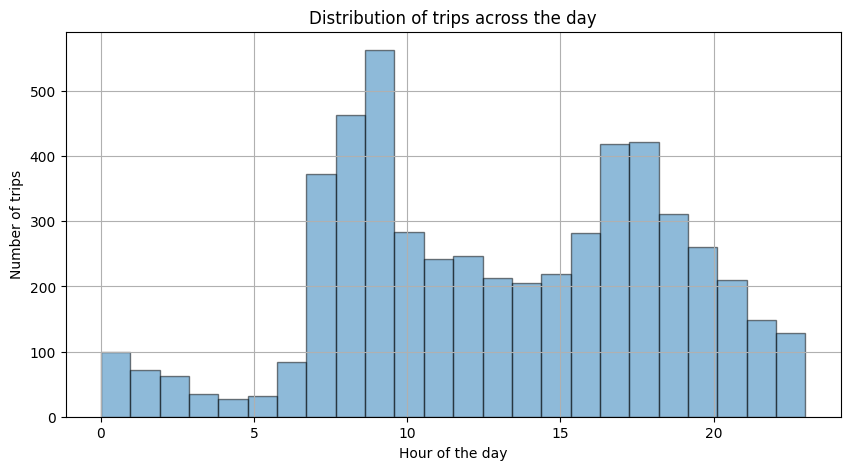

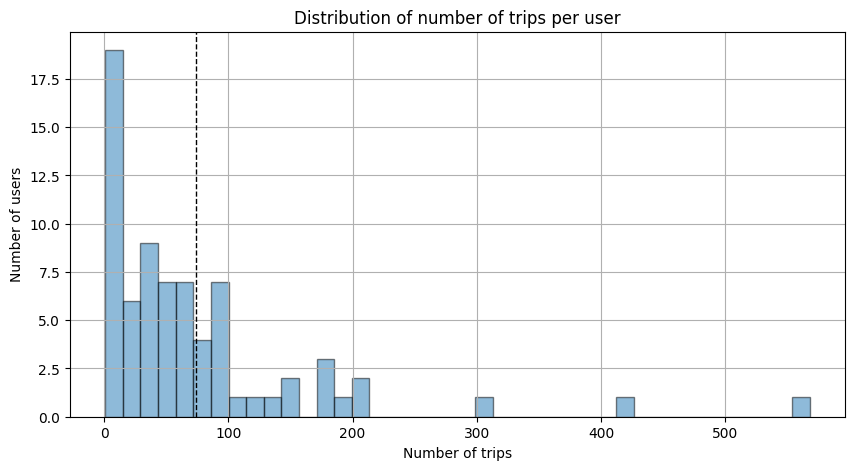

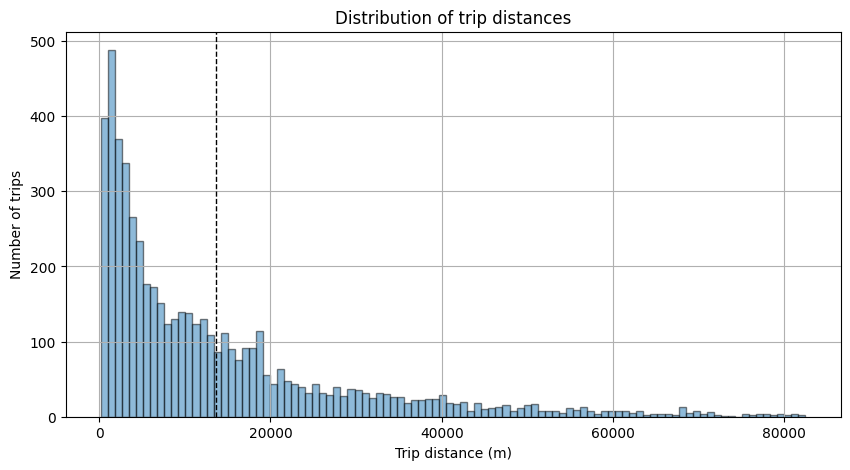

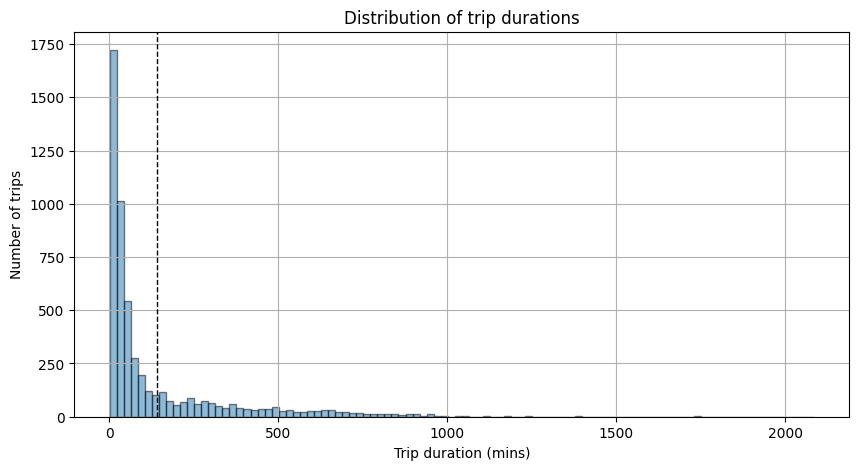


Matching start and end points with tessellation...
Done.

Extracting trips that start and end within tessellation area...
Number of trips that start and end wihin tessellation area: 5101
Number of trips outside and therefore dropped: 299
Done.

Building mapping of trip chains...


100%|███████████████████████████████████████████████████████████████████████████████| 5101/5101 [01:24<00:00, 60.52it/s]


Done.

Evaluating trip chaining...
Number of edges (matched) between trips: 738
Number of wrong matches: 225
Done.

Building trip chains...


100%|████████████████████████████████████████████████████████████████████████████| 5101/5101 [00:00<00:00, 26128.92it/s]


Done.

Merging trips...


100%|███████████████████████████████████████████████████████████████████████████████| 5101/5101 [00:57<00:00, 88.34it/s]


Done.
Number of trips that were matched at least once: 5032/5101
Concatenating MERGED and UNMERGED trips...
Done.

Extracting data for concatenated trips...
Done.

Building clustering after concatenation...
Number of unique clusters: 4432
Done.

Building HL from start points...


/usr/local/lib/python3.8/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 96 disconnected components.
 There are 58 islands with ids: 9, 11, 13, 15, 16, 17, 28, 29, 30, 60, 121, 131, 177, 178, 220, 221, 231, 236, 347, 523, 661, 734, 817, 881, 943, 961, 962, 1020, 1026, 1040, 1041, 1053, 1054, 1055, 1056, 1057, 1063, 1136, 1137, 1195, 1206, 1207, 1208, 1213, 1214, 1220, 1345, 1346, 1347, 1360, 1361, 1362, 1369, 1370, 1371, 1376, 1377, 1415.
  warnings.warn(message)


Done.

Building HL from end points...


/usr/local/lib/python3.8/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 136 disconnected components.
 There are 70 islands with ids: 0, 1, 6, 12, 14, 15, 27, 28, 31, 34, 35, 36, 48, 49, 52, 53, 68, 69, 70, 113, 115, 117, 322, 399, 541, 542, 546, 547, 780, 1148, 1152, 1258, 1259, 1270, 1357, 1464, 1506, 1519, 1521, 1560, 1578, 1579, 1613, 1619, 1629, 1637, 1639, 1640, 1641, 1642, 1647, 1648, 1749, 1751, 1752, 1868, 1869, 1873, 1889, 1892, 1894, 1898, 1902, 2042, 2043, 2049, 2064, 2069, 2070, 2107.
  warnings.warn(message)


Done.

Combining HL from start points and end points...


/usr/local/lib/python3.8/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 144 disconnected components.
 There are 76 islands with ids: 0, 1, 6, 14, 15, 29, 30, 31, 34, 35, 36, 49, 52, 53, 1104, 1105, 1106, 1124, 1154, 1185, 1378, 1380, 1383, 1446, 1447, 1448, 1496, 1567, 1597, 1599, 1600, 1620, 1637, 1646, 1797, 1871, 1873, 1892, 1894, 1900, 1903, 2042, 2049, 2064, 2069, 2107, 2119, 2122, 2123, 2125, 2136, 2138, 2976, 2982, 3058, 3129, 3230, 3237, 3239, 3241, 3244, 3304, 3316, 3317, 3322, 3443, 3453, 3454, 3468, 3469, 3470, 3477, 3479, 3522, 3523, 3524.
  warnings.warn(message)


Number of users for which at least on Home Location has been identified:  72
Number of unique HL tiles: 144
Done.

Matching trips to HL...
Number of unmatched trajectories (concatenated) that do neither start nor end in a HL tile: 69/4432
Number of trajectories (concatenated) that start AND end in a HL tile: 3514/4432
Number of trips that match different HL tiles with their SP and EP: 1248
Done.

Matching double assigned trips to unique HL...


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.
[Parallel(n_jobs=-4)]: Done 201 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-4)]: Done 551 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-4)]: Done 1001 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-4)]: Done 1551 tasks      | elapsed: 28.7min
[Parallel(n_jobs=-4)]: Done 2201 tasks      | elapsed: 37.4min
[Parallel(n_jobs=-4)]: Done 2496 out of 2496 | elapsed: 53.4min finished


All scores are 0.0, assigning -1 as best_hl_id!
All scores are 0.0, assigning -1 as best_hl_id!
Done.

Getting trajectories that happened during the same time...


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.
[Parallel(n_jobs=-4)]: Done 201 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-4)]: Done 551 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-4)]: Done 1001 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-4)]: Done 1551 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-4)]: Done 2201 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-4)]: Done 2951 tasks      | elapsed: 25.8min
[Parallel(n_jobs=-4)]: Done 3801 tasks      | elapsed: 33.3min
[Parallel(n_jobs=-4)]: Done 4432 out of 4432 | elapsed: 38.8min finished


Done.

Building clustering after HL matching step...


  0%|                                                                                            | 0/79 [00:00<?, ?it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Running randomized subset search for 1000 iterations with 2909 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-4)]: Done 550 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:   42.6s finished


Done. Length of longest subset:  125


  6%|█████▎                                                                              | 5/79 [00:43<09:04,  7.35s/it][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Running randomized subset search for 1000 iterations with 218 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-4)]: Done 751 out of 1000 | elapsed:    8.1s remaining:    2.7s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:   10.4s finished


Done. Length of longest subset:  207
Running randomized subset search for 1000 iterations with 32 trajectories...


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.
[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    1.5s finished
  9%|███████▍                                                                            | 7/79 [00:55<08:15,  6.88s/it][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done. Length of longest subset:  32
Running randomized subset search for 1000 iterations with 56 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    1.5s finished
 10%|████████▌                                                                           | 8/79 [00:57<06:44,  5.70s/it][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done. Length of longest subset:  53
Running randomized subset search for 1000 iterations with 53 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    1.5s finished
 14%|███████████▌                                                                       | 11/79 [00:58<03:34,  3.16s/it][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done. Length of longest subset:  53
Running randomized subset search for 1000 iterations with 56 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    1.3s finished
 15%|████████████▌                                                                      | 12/79 [01:00<03:09,  2.83s/it][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done. Length of longest subset:  46
Running randomized subset search for 1000 iterations with 221 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    3.3s finished


Done. Length of longest subset:  96


 18%|██████████████▋                                                                    | 14/79 [01:03<02:38,  2.44s/it][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Running randomized subset search for 1000 iterations with 130 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-4)]: Done 550 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    6.2s finished


Done. Length of longest subset:  130


 23%|██████████████████▉                                                                | 18/79 [01:10<02:03,  2.03s/it][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Running randomized subset search for 1000 iterations with 275 trajectories...


[Parallel(n_jobs=-4)]: Done 201 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    7.5s finished


Done. Length of longest subset:  176


 28%|███████████████████████                                                            | 22/79 [01:17<01:54,  2.01s/it][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Running randomized subset search for 1000 iterations with 63 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    1.6s finished
 29%|████████████████████████▏                                                          | 23/79 [01:19<01:50,  1.98s/it]

Done. Length of longest subset:  63


 47%|██████████████████████████████████████▊                                            | 37/79 [01:19<00:23,  1.80it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Running randomized subset search for 1000 iterations with 41 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    1.4s finished
 65%|█████████████████████████████████████████████████████▌                             | 51/79 [01:21<00:08,  3.46it/s]

Done. Length of longest subset:  41


100%|███████████████████████████████████████████████████████████████████████████████████| 79/79 [01:21<00:00,  1.03s/it]


Done.

Clustering results after concatenation step:
Number of unique clusters: 4432
Homogeneity: 0.986
Completeness: 0.437
V-measure: 0.606
Rand index: 0.965
ARI: 0.003
MI: 3.649
NMI: 0.606
AMI: 0.054
Cluster accuracy: 0.027

Clustering results after HL matching step:
Number of unique clusters: 3183
Homogeneity: 0.920
Completeness: 0.475
V-measure: 0.627
Rand index: 0.967
ARI: 0.188
MI: 3.406
NMI: 0.627
AMI: 0.268
Cluster accuracy: 0.204


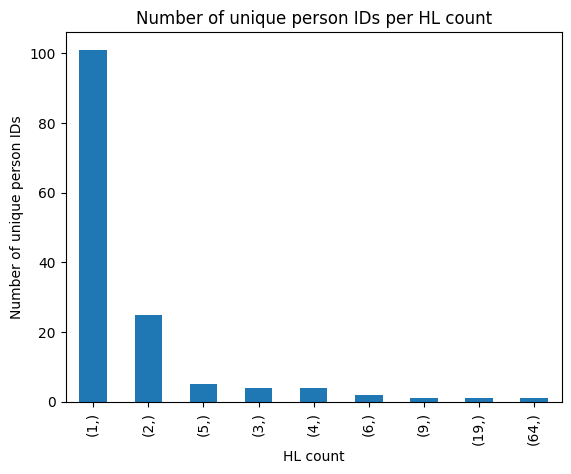

In [12]:
# Run attack on private data with big tessellation
attack.plot_hour_of_day_distribution(raw_full_trip_gdf)
attack.plot_distribution_of_number_of_trips_per_user(raw_full_trip_gdf)
attack.plot_distribution_of_trip_distances(raw_full_trip_gdf)
attack.plot_distribution_of_trip_durations(raw_full_trip_gdf)

# Merge Start Points (SP) and End Points (EP) with Tessellation
print("\nMatching start and end points with tessellation...")
gdf_sp, gdf_ep = attack.match_boundary_points_with_tessellation(raw_trip_sp_gdf, raw_trip_ep_gdf, tesselation_gdf)
print("Done.")

# Extract Full Trips that Start and End within Tessellation Area
print("\nExtracting trips that start and end within tessellation area...")
full_trip_gdf, trip_sp_gdf, trip_ep_gdf, gdf_sp, gdf_ep = attack.extract_trips_that_start_end_in_tessellation(raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf, gdf_sp, gdf_ep)
print("Done.")

# Build mapping of trip chains
print('\nBuilding mapping of trip chains...')
mapping_cont_trips = attack.build_trip_chain_mapping(gdf_sp, gdf_ep)
print('Done.')

# Evaluate Trip Chaining
print('\nEvaluating trip chaining...')
attack.evaluate_trip_chaining(mapping_cont_trips, full_trip_gdf)
print('Done.')

# Concatenate Trips
full_trips_concat_gdf, trip_concat_dict = attack.merge_trips_from_matching(gdf_sp, mapping_cont_trips, full_trip_gdf)

# Extract data for concatenated trips
print('\nExtracting data for concatenated trips...')
gdf_sp_concat, trip_sp_gdf_concat, gdf_ep_concat, trip_ep_gdf_concat = attack.extract_concatenated_trips(full_trips_concat_gdf, gdf_sp, trip_sp_gdf, gdf_ep, trip_ep_gdf)
print('Done.')

# Build Clustering after Concatenation step
print('\nBuilding clustering after concatenation...')
clustering_concat = attack.build_clustering_after_concatenation(full_trips_concat_gdf, trip_concat_dict, full_trip_gdf)
print('Done.')

# Build Home Locations (HL)
# Build HL from Start Points
print('\nBuilding HL from start points...')
gdf_hl_combined_sp = attack.build_hl_from_start_points(gdf_sp, gdf_ep, HL_SP_OUTFLOW_THRESHOLD=HL_SP_OUTFLOW_THRESHOLD)
print('Done.')
# Build HL from End Points
print('\nBuilding HL from end points...')
gdf_hl_combined_ep = attack.build_hl_from_end_points(gdf_sp, gdf_ep, HL_EP_OUTFLOW_THRESHOLD=HL_EP_OUTFLOW_THRESHOLD)
print('Done.')
# Combine HL from Start Points and End Points
print('\nCombining HL from start points and end points...')
gp_combined, HL_table = attack.concatenate_hl(gdf_hl_combined_sp, gdf_hl_combined_ep)
print('Done.')

print('\nMatching trips to HL...')
HL_table_se_concat, unmatched_trips, double_assigned_trips, nr_unmatched = attack.match_trips_to_HL(gp_combined, HL_table, trip_sp_gdf_concat, trip_ep_gdf_concat, full_trips_concat_gdf)
print('Done.')

print('\nMatching double assigned trips to unique HL...')
HL_table_trips_concat = attack.assign_double_matched_trips_to_unique_hl(HL_table_se_concat, full_trips_concat_gdf, unmatched_trips, double_assigned_trips, nr_unmatched)
print('Done.')

# Get trajectories that happened during the same time
print('\nGetting trajectories that happened during the same time...')
full_trips_concat_gdf_overlap_dict = attack.getTripOverlaps(full_trips_concat_gdf)
print('Done.')

# Build Clustering after HL matching step
print('\nBuilding clustering after HL matching step...')
clustering_after_HL, HL_table_dict = attack.build_clustering_after_HL_assignment(HL_table_trips_concat, full_trip_gdf, trip_concat_dict, full_trips_concat_gdf_overlap_dict)
print('Done.')

# Evaluate clustering Results
print("\nClustering results after concatenation step:")
print(f"Number of unique clusters: {len(set(clustering_concat))}")
attack.evaluate(clustering_concat, full_trip_gdf)
clustering_HL = list(dict(sorted(clustering_after_HL.items())).values())
print("\nClustering results after HL matching step:")
print(f"Number of unique clusters: {len(set(clustering_HL))}")
attack.evaluate(clustering_HL, full_trip_gdf)

In [13]:
full_trip_gdf = full_trip_gdf.copy()
full_trip_gdf['clustering_HL'] = clustering_HL
full_trip_gdf.to_file('../data/geolife/geolife_clustering_HL_500tessellation.geojson', driver="GeoJSON")

/usr/local/lib/python3.8/dist-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [8]:
# Load preprocessed data 
raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf, tesselation_gdf = dl.load_geolife(data_type='private', 
                                                                                       min_n_trips_per_user=1,
                                                                                       rand_n_week_period=None,
                                                                                       tessellation_diameter=500,
                                                                                       min_trip_length=200,
                                                                                       min_nr_points=50,
                                                                                       upper_quantile_length=0.95,
                                                                                       only_2008=True)
assert len(raw_full_trip_gdf) == len(raw_trip_sp_gdf) == len(raw_trip_ep_gdf)

Reading private geolife geojson file...
Done.
Number of trajectories in loaded dataset: 4719
Number of users in loaded dataset: 73


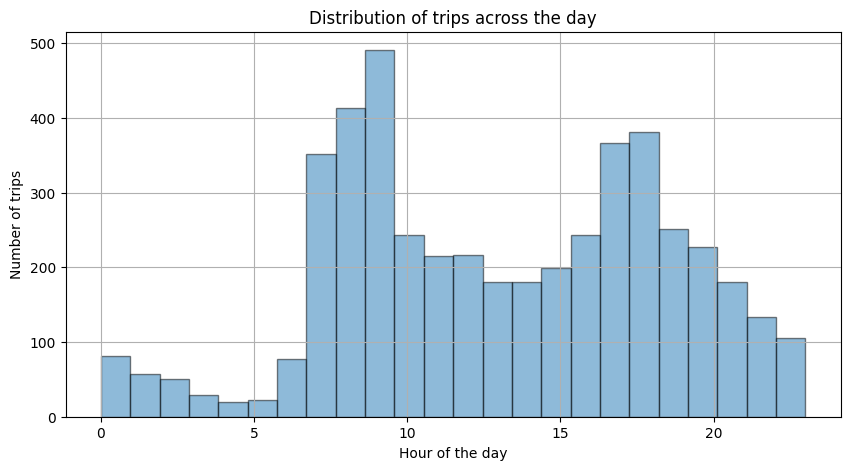

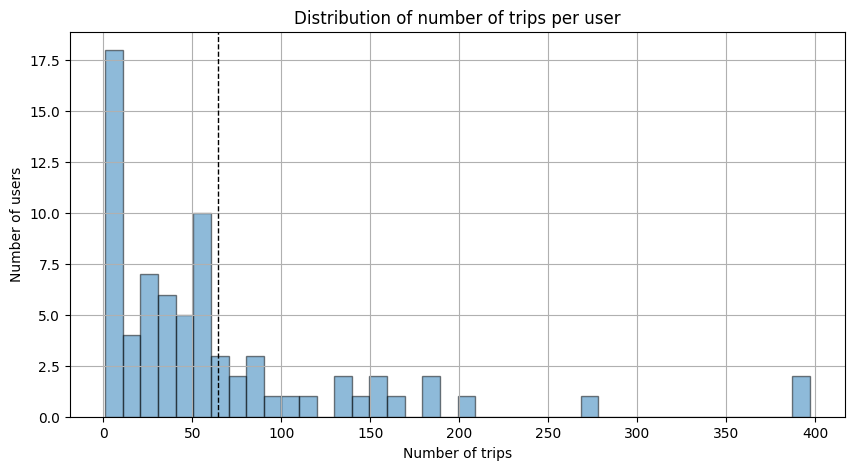

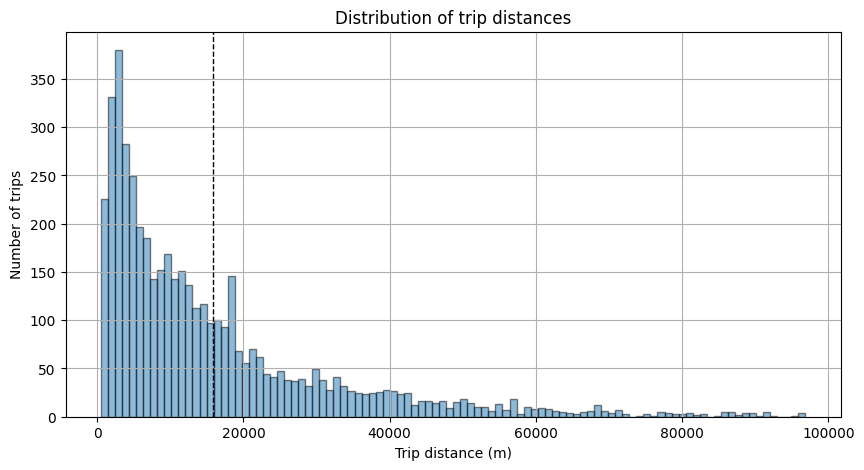

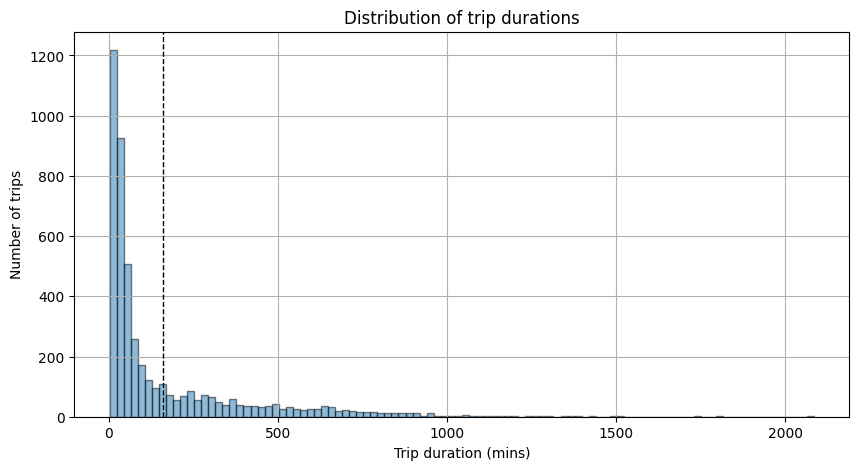


Matching start and end points with tessellation...
Done.

Extracting trips that start and end within tessellation area...
Number of trips that start and end wihin tessellation area: 4449
Number of trips outside and therefore dropped: 270
Done.

Building mapping of trip chains...


100%|███████████████████████████████████████████████████████████████████████████████| 4449/4449 [01:10<00:00, 63.01it/s]


Done.

Evaluating trip chaining...
Number of edges (matched) between trips: 394
Number of wrong matches: 182
Done.

Building trip chains...


100%|████████████████████████████████████████████████████████████████████████████| 4449/4449 [00:00<00:00, 56389.64it/s]


Done.

Merging trips...


100%|███████████████████████████████████████████████████████████████████████████████| 4449/4449 [00:51<00:00, 86.91it/s]


Done.
Number of trips that were matched at least once: 4410/4449
Concatenating MERGED and UNMERGED trips...
Done.

Extracting data for concatenated trips...
Done.

Building clustering after concatenation...
Number of unique clusters: 4094
Done.

Building HL from start points...


/usr/local/lib/python3.8/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 96 disconnected components.
 There are 58 islands with ids: 5, 9, 12, 13, 14, 25, 26, 27, 34, 93, 106, 141, 175, 194, 197, 198, 313, 314, 572, 706, 856, 862, 903, 913, 914, 921, 922, 924, 929, 940, 942, 943, 954, 955, 956, 957, 1029, 1030, 1076, 1080, 1081, 1086, 1087, 1088, 1089, 1196, 1197, 1198, 1209, 1214, 1215, 1216, 1224, 1225, 1229, 1240, 1267, 1270.
  warnings.warn(message)


Done.

Building HL from end points...


/usr/local/lib/python3.8/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 121 disconnected components.
 There are 60 islands with ids: 0, 1, 5, 6, 10, 11, 18, 25, 26, 27, 31, 43, 44, 47, 48, 62, 96, 163, 183, 324, 328, 441, 452, 1000, 1100, 1158, 1319, 1335, 1348, 1349, 1357, 1365, 1369, 1411, 1432, 1444, 1454, 1471, 1474, 1475, 1510, 1598, 1600, 1627, 1628, 1680, 1692, 1709, 1712, 1713, 1718, 1726, 1859, 1861, 1862, 1874, 1879, 1880, 1881, 1916.
  warnings.warn(message)


Done.

Combining HL from start points and end points...


/usr/local/lib/python3.8/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 139 disconnected components.
 There are 82 islands with ids: 0, 1, 5, 10, 11, 20, 25, 26, 27, 31, 46, 47, 48, 79, 1057, 1089, 1268, 1309, 1311, 1333, 1336, 1345, 1353, 1362, 1363, 1364, 1386, 1387, 1457, 1581, 1582, 1623, 1624, 1685, 1686, 1694, 1713, 1715, 1718, 1858, 1859, 1862, 1863, 1874, 1879, 1916, 1926, 1929, 1931, 1942, 2671, 2672, 2674, 2769, 2779, 2838, 2839, 2840, 2932, 2933, 2939, 2940, 2941, 2942, 2946, 2997, 3003, 3004, 3005, 3006, 3113, 3114, 3115, 3130, 3131, 3132, 3133, 3142, 3146, 3185, 3186, 3187.
  warnings.warn(message)


Number of users for which at least on Home Location has been identified:  71
Number of unique HL tiles: 139
Done.

Matching trips to HL...
Number of unmatched trajectories (concatenated) that do neither start nor end in a HL tile: 89/4094
Number of trajectories (concatenated) that start AND end in a HL tile: 3094/4094
Number of trips that match different HL tiles with their SP and EP: 1108
Done.

Matching double assigned trips to unique HL...


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.
[Parallel(n_jobs=-4)]: Done 201 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-4)]: Done 551 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-4)]: Done 1001 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-4)]: Done 1551 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-4)]: Done 2216 out of 2216 | elapsed: 30.6min finished
[Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


All scores are 0.0, assigning -1 as best_hl_id!
All scores are 0.0, assigning -1 as best_hl_id!
All scores are 0.0, assigning -1 as best_hl_id!
Done.

Getting trajectories that happened during the same time...


[Parallel(n_jobs=-4)]: Done 201 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-4)]: Done 551 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-4)]: Done 1001 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-4)]: Done 1551 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-4)]: Done 2201 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-4)]: Done 2951 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-4)]: Done 3801 tasks      | elapsed: 26.9min
[Parallel(n_jobs=-4)]: Done 4094 out of 4094 | elapsed: 29.0min finished


Done.

Building clustering after HL matching step...


  0%|                                                                                            | 0/73 [00:00<?, ?it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Running randomized subset search for 1000 iterations with 2686 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-4)]: Done 550 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:   34.4s finished
  3%|██▎                                                                                 | 2/73 [00:34<20:26, 17.28s/it][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done. Length of longest subset:  89
Running randomized subset search for 1000 iterations with 32 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    1.4s finished
  4%|███▍                                                                                | 3/73 [00:36<12:28, 10.70s/it][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done. Length of longest subset:  32
Running randomized subset search for 1000 iterations with 33 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    1.3s finished
  8%|██████▉                                                                             | 6/73 [00:37<04:37,  4.14s/it][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done. Length of longest subset:  33
Running randomized subset search for 1000 iterations with 220 trajectories...


[Parallel(n_jobs=-4)]: Done 202 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-4)]: Done 751 out of 1000 | elapsed:    8.4s remaining:    2.8s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:   10.8s finished


Done. Length of longest subset:  199


 11%|█████████▏                                                                          | 8/73 [00:48<05:04,  4.69s/it][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Running randomized subset search for 1000 iterations with 57 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    1.5s finished
 12%|██████████▎                                                                         | 9/73 [00:50<04:18,  4.04s/it][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done. Length of longest subset:  46
Running randomized subset search for 1000 iterations with 58 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    1.3s finished
 15%|████████████▌                                                                      | 11/73 [00:51<02:52,  2.78s/it][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done. Length of longest subset:  46
Running randomized subset search for 1000 iterations with 274 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    3.5s finished
 16%|█████████████▋                                                                     | 12/73 [00:55<03:00,  2.97s/it]

Done. Length of longest subset:  99
Running randomized subset search for 1000 iterations with 119 trajectories...


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.
[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    3.3s finished


Done. Length of longest subset:  119


 25%|████████████████████▍                                                              | 18/73 [00:58<01:19,  1.44s/it][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Running randomized subset search for 1000 iterations with 244 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    5.4s finished


Done. Length of longest subset:  132


 51%|██████████████████████████████████████████                                         | 37/73 [01:04<00:16,  2.17it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Running randomized subset search for 1000 iterations with 43 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    1.5s finished
 59%|████████████████████████████████████████████████▉                                  | 43/73 [01:06<00:12,  2.46it/s]

Done. Length of longest subset:  43


 92%|████████████████████████████████████████████████████████████████████████████▏      | 67/73 [01:06<00:00,  6.15it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Running randomized subset search for 1000 iterations with 50 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    1.3s finished
100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [01:07<00:00,  1.08it/s]


Done. Length of longest subset:  50
Done.

Clustering results after concatenation step:
Number of unique clusters: 4094
Homogeneity: 0.986
Completeness: 0.441
V-measure: 0.609
Rand index: 0.967
ARI: 0.001
MI: 3.650
NMI: 0.609
AMI: 0.025
Cluster accuracy: 0.026

Clustering results after HL matching step:
Number of unique clusters: 3092
Homogeneity: 0.928
Completeness: 0.475
V-measure: 0.628
Rand index: 0.969
ARI: 0.195
MI: 3.435
NMI: 0.628
AMI: 0.231
Cluster accuracy: 0.190


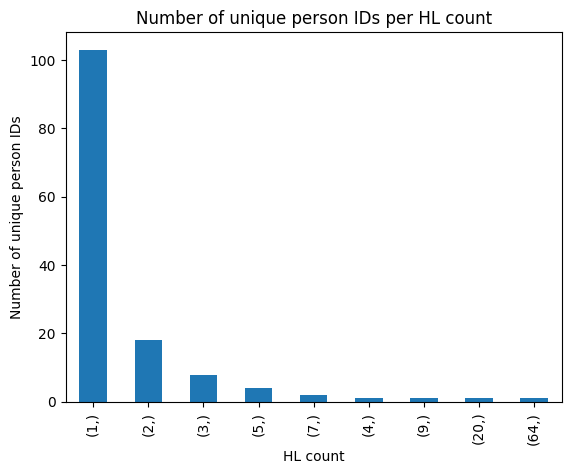

In [9]:
# Run attack on private data with big tessellation
attack.plot_hour_of_day_distribution(raw_full_trip_gdf)
attack.plot_distribution_of_number_of_trips_per_user(raw_full_trip_gdf)
attack.plot_distribution_of_trip_distances(raw_full_trip_gdf)
attack.plot_distribution_of_trip_durations(raw_full_trip_gdf)

# Merge Start Points (SP) and End Points (EP) with Tessellation
print("\nMatching start and end points with tessellation...")
gdf_sp, gdf_ep = attack.match_boundary_points_with_tessellation(raw_trip_sp_gdf, raw_trip_ep_gdf, tesselation_gdf)
print("Done.")

# Extract Full Trips that Start and End within Tessellation Area
print("\nExtracting trips that start and end within tessellation area...")
full_trip_gdf, trip_sp_gdf, trip_ep_gdf, gdf_sp, gdf_ep = attack.extract_trips_that_start_end_in_tessellation(raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf, gdf_sp, gdf_ep)
print("Done.")

# Build mapping of trip chains
print('\nBuilding mapping of trip chains...')
mapping_cont_trips = attack.build_trip_chain_mapping(gdf_sp, gdf_ep)
print('Done.')

# Evaluate Trip Chaining
print('\nEvaluating trip chaining...')
attack.evaluate_trip_chaining(mapping_cont_trips, full_trip_gdf)
print('Done.')

# Concatenate Trips
full_trips_concat_gdf, trip_concat_dict = attack.merge_trips_from_matching(gdf_sp, mapping_cont_trips, full_trip_gdf)

# Extract data for concatenated trips
print('\nExtracting data for concatenated trips...')
gdf_sp_concat, trip_sp_gdf_concat, gdf_ep_concat, trip_ep_gdf_concat = attack.extract_concatenated_trips(full_trips_concat_gdf, gdf_sp, trip_sp_gdf, gdf_ep, trip_ep_gdf)
print('Done.')

# Build Clustering after Concatenation step
print('\nBuilding clustering after concatenation...')
clustering_concat = attack.build_clustering_after_concatenation(full_trips_concat_gdf, trip_concat_dict, full_trip_gdf)
print('Done.')

# Build Home Locations (HL)
# Build HL from Start Points
print('\nBuilding HL from start points...')
gdf_hl_combined_sp = attack.build_hl_from_start_points(gdf_sp, gdf_ep, HL_SP_OUTFLOW_THRESHOLD=HL_SP_OUTFLOW_THRESHOLD)
print('Done.')
# Build HL from End Points
print('\nBuilding HL from end points...')
gdf_hl_combined_ep = attack.build_hl_from_end_points(gdf_sp, gdf_ep, HL_EP_OUTFLOW_THRESHOLD=HL_EP_OUTFLOW_THRESHOLD)
print('Done.')
# Combine HL from Start Points and End Points
print('\nCombining HL from start points and end points...')
gp_combined, HL_table = attack.concatenate_hl(gdf_hl_combined_sp, gdf_hl_combined_ep)
print('Done.')

print('\nMatching trips to HL...')
HL_table_se_concat, unmatched_trips, double_assigned_trips, nr_unmatched = attack.match_trips_to_HL(gp_combined, HL_table, trip_sp_gdf_concat, trip_ep_gdf_concat, full_trips_concat_gdf)
print('Done.')

print('\nMatching double assigned trips to unique HL...')
HL_table_trips_concat = attack.assign_double_matched_trips_to_unique_hl(HL_table_se_concat, full_trips_concat_gdf, unmatched_trips, double_assigned_trips, nr_unmatched)
print('Done.')

# Get trajectories that happened during the same time
print('\nGetting trajectories that happened during the same time...')
full_trips_concat_gdf_overlap_dict = attack.getTripOverlaps(full_trips_concat_gdf)
print('Done.')

# Build Clustering after HL matching step
print('\nBuilding clustering after HL matching step...')
clustering_after_HL, HL_table_dict = attack.build_clustering_after_HL_assignment(HL_table_trips_concat, full_trip_gdf, trip_concat_dict, full_trips_concat_gdf_overlap_dict)
print('Done.')

# Evaluate clustering Results
print("\nClustering results after concatenation step:")
print(f"Number of unique clusters: {len(set(clustering_concat))}")
attack.evaluate(clustering_concat, full_trip_gdf)
clustering_HL = list(dict(sorted(clustering_after_HL.items())).values())
print("\nClustering results after HL matching step:")
print(f"Number of unique clusters: {len(set(clustering_HL))}")
attack.evaluate(clustering_HL, full_trip_gdf)

In [10]:
full_trip_gdf = full_trip_gdf.copy()
full_trip_gdf['clustering_HL'] = clustering_HL
full_trip_gdf.to_file('../data/geolife/geolife_clustering_HL_private_500tessellation.geojson', driver="GeoJSON")

/usr/local/lib/python3.8/dist-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# Merge Start Points (SP) and End Points (EP) with Tessellation

In [7]:
gdf_sp, gdf_ep = attack.match_boundary_points_with_tessellation(raw_trip_sp_gdf, raw_trip_ep_gdf, tesselation_gdf)

# Extract Full Trips that Start and End within Tessellation Area

In [8]:
full_trip_gdf, trip_sp_gdf, trip_ep_gdf, gdf_sp, gdf_ep = attack.extract_trips_that_start_end_in_tessellation(raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf, gdf_sp, gdf_ep)


Number of trips that start and end wihin tessellation area: 290
Number of trips outside and therefore dropped: 22


## Build mapping of trip chains

In [9]:
mapping_cont_trips = attack.build_trip_chain_mapping(gdf_sp, gdf_ep)

100%|██████████| 290/290 [00:05<00:00, 57.81it/s]


In [10]:
attack.evaluate_trip_chaining(mapping_cont_trips, full_trip_gdf)

Number of edges (matched) between trips: 73
Number of wrong matches: 0


## Merge trips according to matching

In [11]:
full_trips_concat_gdf, trip_concat_dict = attack.merge_trips_from_matching(gdf_sp, mapping_cont_trips, full_trip_gdf)


Building trip chains...


100%|██████████| 290/290 [00:00<00:00, 96704.42it/s]


Done.

Merging trips...


100%|██████████| 290/290 [00:04<00:00, 65.87it/s]

Done.
Number of trips that were matched at least once: 289/290
Concatenating MERGED and UNMERGED trips...
Done.


In [12]:
gdf_sp_concat, trip_sp_gdf_concat, gdf_ep_concat, trip_ep_gdf_concat = attack.extract_concatenated_trips(full_trips_concat_gdf, gdf_sp, trip_sp_gdf, gdf_ep, trip_ep_gdf)

## Build Clustering after Concatenation Step

In [13]:
clustering_concat = attack.build_clustering_after_concatenation(full_trips_concat_gdf, trip_concat_dict, full_trip_gdf)

Number of unique clusters: 218


# Build Home Locations (HL)

## From Start Points (SPs)

We use the SP-tessellation matching that still contains all SP (and potential HL), and not just the SP and EP of the concatenated trips. We do this, because we do not want loose potential HL contributed of substrip concatenated in a chain.

In [14]:
gdf_hl_combined_sp = attack.build_hl_from_start_points(gdf_sp)

c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 16 disconnected components.
 There are 9 islands with ids: 12, 14, 15, 18, 20, 26, 27, 49, 51.
  warnings.warn(message)


## From End Points (EPs)

In [15]:
gdf_hl_combined_ep = attack.build_hl_from_end_points(gdf_ep)

c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 32 disconnected components.
 There are 24 islands with ids: 5, 28, 29, 30, 38, 39, 40, 41, 42, 49, 50, 53, 54, 58, 59, 60, 63, 64, 73, 74, 79, 110, 111, 112.
  warnings.warn(message)


## Merge (concatenate)

c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 40 disconnected components.
 There are 29 islands with ids: 15, 55, 56, 58, 59, 60, 61, 62, 70, 71, 76, 77, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 149, 151, 152, 153, 158, 159, 164.
  warnings.warn(message)


Number of users for which at least on Home Location has been identified:  5
Number of unique HL tiles: 40


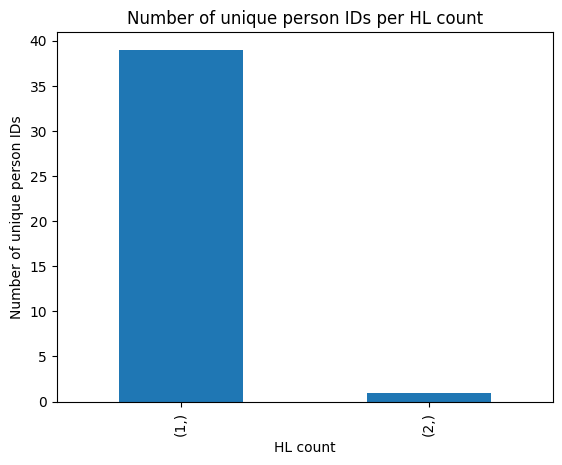

In [16]:
gp_combined, HL_table = attack.concatenate_hl(gdf_hl_combined_sp, gdf_hl_combined_ep)

# Match trips with Home Location tiles

## Match concatenated trips

In [17]:
HL_table_se_concat, unmatched_trips, double_assigned_trips, nr_unmatched = attack.match_trips_to_HL(gp_combined, HL_table, trip_sp_gdf_concat, trip_ep_gdf_concat, full_trips_concat_gdf)

Number of unmatched trajectories (concatenated) that do neither start nor end in a HL tile: 10/218
Number of trajectories (concatenated) that start AND end in a HL tile: 74/218
Number of trips that match different HL tiles with their SP and EP: 44


## Assign double matched trips to one unique HL

Iterate over all double matched trips and compare them to all other trips that are uniquely assigned in their respective potential HLs that they have been matched with. Then take the HL with the single maximum lcss score between the trip under question and any trip of the assigned HL tiles.

In [18]:
HL_table_trips_concat = attack.assign_double_matched_trips_to_unique_hl(HL_table_se_concat, full_trips_concat_gdf, unmatched_trips, double_assigned_trips, nr_unmatched)


## Get trajectories that happened during the same time

In [19]:
full_trips_concat_gdf_overlap_dict = attack.getTripOverlaps(full_trips_concat_gdf)

## Create clustering after HL assignment step

In [20]:
clustering_after_HL, HL_table_dict = attack.build_clustering_after_HL_assignment(HL_table_trips_concat, full_trip_gdf, trip_concat_dict, full_trips_concat_gdf_overlap_dict)

  0%|          | 0/26 [00:00<?, ?it/s]

Running randomized subset search for 200 iterations with 37 trajectories...


 12%|█▏        | 3/26 [00:00<00:05,  4.39it/s]

Done. Length of longest subset:  37
Running randomized subset search for 200 iterations with 59 trajectories...


 42%|████▏     | 11/26 [00:01<00:02,  5.87it/s]

Done. Length of longest subset:  59
Running randomized subset search for 200 iterations with 45 trajectories...


100%|██████████| 26/26 [00:02<00:00, 10.46it/s]

Done. Length of longest subset:  45


In [21]:
print("Clustering results after concatenation step:")
print(f"Number of unique clusters: {len(set(clustering_concat))}")
attack.evaluate(clustering_concat, full_trip_gdf)

clustering_HL = list(dict(sorted(clustering_after_HL.items())).values())
print("\nClustering results after HL matching step:")
print(f"Number of unique clusters: {len(set(clustering_HL))}")
attack.evaluate(clustering_HL, full_trip_gdf)

Clustering results after concatenation step:
Number of unique clusters: 218
Homogeneity: 1.000
Completeness: 0.182
V-measure: 0.308
Rand index: 0.534
ARI: 0.005
MI: 0.963
NMI: 0.308
AMI: 0.081

Clustering results after HL matching step:
Number of unique clusters: 34
Homogeneity: 0.974
Completeness: 0.414
V-measure: 0.581
Rand index: 0.697
ARI: 0.368
MI: 0.938
NMI: 0.581
AMI: 0.541


## Try to Assign Trips Without Match

In [22]:
clustering_after_double_assign_HL = attack.assign_trips_without_match(
    clustering_after_HL, HL_table_dict, 
    full_trips_concat_gdf, 
    full_trips_concat_gdf_overlap_dict, 
    full_trip_gdf, 
    trip_concat_dict)


Comparing trips that were not assigned to any HL_ID with trips that were assigned to a HL_ID...


 10%|█         | 1/10 [00:05<00:46,  5.11s/it]

no match and assign new cluster id 35 to trips 11 100


 20%|██        | 2/10 [00:08<00:30,  3.82s/it]

LCSS scores too low to match


 30%|███       | 3/10 [00:10<00:23,  3.35s/it]

existing match and assign cluster id 2.0 to trip 262


 40%|████      | 4/10 [00:15<00:22,  3.78s/it]

existing match and assign cluster id 2.0 to trip 255


 50%|█████     | 5/10 [00:19<00:19,  4.00s/it]

existing match and assign cluster id 6.0 to trip 253


 60%|██████    | 6/10 [00:20<00:11,  2.94s/it]

existing match and assign cluster id 2.0 to trip 1


 70%|███████   | 7/10 [00:23<00:08,  2.89s/it]

existing match and assign cluster id 5.0 to trip 51
There are two or more HL_IDs with the same LCSS score. Looking for second highest LCSS score...
Candidate HL_IDs: [-1.0, 15.0, 17.0]


 80%|████████  | 8/10 [00:29<00:07,  3.81s/it]

There is a unique highest score
The highest score is 1.0 and the best_hl_id is 15.0
existing match and assign cluster id 15.0 to trip 64
There are two or more HL_IDs with the same LCSS score. Looking for second highest LCSS score...
Candidate HL_IDs: [15.0, 18.0]


100%|██████████| 10/10 [00:30<00:00,  3.04s/it]

There is a unique highest score
The highest score is 1.0 and the best_hl_id is 15.0
existing match and assign cluster id 15.0 to trip 101
Done.
Assigning clustering IDs to all trips that are part of a new cluster...
Done.


In [23]:
print("Clustering results after concatenation step:")
print(f"Number of unique clusters: {len(set(clustering_concat))}")
attack.evaluate(clustering_concat, full_trip_gdf)

print("\nClustering results after HL matching step:")
print(f"Number of unique clusters: {len(set(list(dict(sorted(clustering_after_HL.items())).values())))}")
attack.evaluate(list(dict(sorted(clustering_after_HL.items())).values()), full_trip_gdf)

print("\nClustering results after double assign HL step:")
print(f"Number of unique clusters: {len(set(list(dict(sorted(clustering_after_double_assign_HL.items())).values())))}")
attack.evaluate(list(dict(sorted(clustering_after_double_assign_HL.items())).values()), full_trip_gdf)

Clustering results after concatenation step:
Number of unique clusters: 218
Homogeneity: 1.000
Completeness: 0.182
V-measure: 0.308
Rand index: 0.534
ARI: 0.005
MI: 0.963
NMI: 0.308
AMI: 0.081

Clustering results after HL matching step:
Number of unique clusters: 34
Homogeneity: 0.974
Completeness: 0.414
V-measure: 0.581
Rand index: 0.697
ARI: 0.368
MI: 0.938
NMI: 0.581
AMI: 0.541

Clustering results after double assign HL step:
Number of unique clusters: 27
Homogeneity: 0.950
Completeness: 0.422
V-measure: 0.584
Rand index: 0.702
ARI: 0.378
MI: 0.915
NMI: 0.584
AMI: 0.551


In [32]:
attack.store_results(clustering_concat, list(dict(sorted(clustering_after_HL.items())).values()), list(dict(sorted(clustering_after_double_assign_HL.items())).values()), full_trip_gdf)